In [ ]:
#upload archive.zip to runtime directly
#loading from mydrive takes forever
import time
from zipfile import ZipFile

start_time = time.time()
!unzip archive.zip
end_time = time.time()
print(f"Took {((end_time - start_time) / 60):.3f} minutes to unzip")

unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.
Took 0.018 minutes to unzip


In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive/')

MessageError: ignored

In [ ]:
!ls .

archive.zip  drive  full_emoji.csv  image  sample_data


In [ ]:
!pip install -q -U einops datasets matplotlib tqdm
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

     |████████████████████████████████| 41 kB 423 kB/s 
     |████████████████████████████████| 451 kB 12.0 MB/s 
     |████████████████████████████████| 9.4 MB 59.9 MB/s 
     |████████████████████████████████| 182 kB 71.5 MB/s 
     |████████████████████████████████| 212 kB 77.8 MB/s 
     |████████████████████████████████| 132 kB 59.7 MB/s 
     |████████████████████████████████| 127 kB 78.1 MB/s 
     |████████████████████████████████| 965 kB 65.7 MB/s 
     |████████████████████████████████| 295 kB 81.0 MB/s 


In [ ]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [ ]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)

class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [ ]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [ ]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4 ##여기
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )# why sinusodial and why *4 why feed it through linearly
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

In [ ]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [ ]:
#timesteps = 100
TIME_STEPS = 1000
# define beta schedule
betas = cosine_beta_schedule(timesteps=TIME_STEPS)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [ ]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [ ]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [ ]:
!ls

archive.zip  full_emoji.csv  image  sample_data


In [ ]:
import os
from PIL import Image
import torchvision
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
DATASET_PATH = "image/"

IMAGE_SIZE = 32
CHANNELS = 4
BATCH_SIZE = 128
NUM_WORKERS= 2

class EmojiDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        #open all the folders
        self.transform = transform
        self.image_dir = root
        self.image_list=[]
        for dir_name, _, file_list in os.walk(root):
          for file in file_list:
            if file :
              self.image_list.append(os.path.join(dir_name, file))

        self.num_images = len(self.image_list)

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        with open(os.path.join(self.image_list[idx]), "rb") as f:
            img = Image.open(f).convert("RGBA")
        return self.transform(img)

def create_emoji_dataset():
    dataset = EmojiDataset(
        root=DATASET_PATH,
        transform = Compose([
            transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
        ])
    )
    return dataset

def create_emoji_loader(dataset, num_workers, batch_size):
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        drop_last=True,
        prefetch_factor = 8, pin_memory=True, persistent_workers=True
    )
    return loader

In [ ]:
train_dataset = create_emoji_dataset()
emoji_dataloader = create_emoji_loader(train_dataset, num_workers=NUM_WORKERS,batch_size=BATCH_SIZE)

In [ ]:
from numpy import zeros
batch = next(iter(emoji_dataloader))
emoji = batch[0]
emoji3 = emoji[:3,:,:]

zeros = torch.zeros(4,28,28)
x = batch[0,0,:,:]
zeros[0,:,:] = x
x = zeros

zeros = torch.zeros(4,28,28)
y = batch[0,1,:,:]
zeros[1,:,:] = y
y = zeros

zeros = torch.zeros(4,28,28)
z = batch[0,2,:,:]
zeros[2,:,:] = z
z = zeros

zeros = torch.zeros(4,28,28)
k = batch[0,3,:,:]
zeros[3,:,:] = k
KeyboardInterrupt = zeros


In [ ]:
import numpy as np

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])
reverse_transform(x.squeeze())

In [ ]:
reverse_transform(y.squeeze())

In [ ]:
reverse_transform(z.squeeze())

In [ ]:
reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     #Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     #Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])
reverse_transform(k.squeeze())

In [ ]:
reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])
print(emoji.shape)
reverse_transform(emoji.squeeze())


torch.Size([4, 28, 28])


In [ ]:
import numpy as np

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])
print(emoji3.shape)
reverse_transform(emoji3.squeeze())

torch.Size([3, 28, 28])


In [ ]:
print(f"Number of training samples: {len(emoji_dataloader)}")
batch = next(iter(emoji_dataloader))
#print(batch[0][1])

In [ ]:
prog_bar = tqdm(emoji_dataloader, total=len(emoji_dataloader))
for step, batch in enumerate(prog_bar):
  print(batch.shape)

In [ ]:
@torch.no_grad()
def p_sample(model, x, t, t_index, clip_denoised):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # clip following https://github.com/hojonathanho/diffusion/issues/5
    if clip_denoised:
      alphas_t = extract(alphas, t, x.shape)
      alphas_cumprod_t = extract(alphas_cumprod, t, x.shape)
      alphas_cumprod_prev_t = extract(alphas_cumprod_prev, t, x.shape)
      sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x.shape)

      model_noise = model(x, t)
      x_recon = ((1/sqrt_alphas_cumprod_t) * x) - (torch.sqrt((1 - alphas_cumprod_t)/alphas_cumprod_t) * model_noise)
      x_recon = torch.clip(x_recon, -1, 1)
      x_recon *= (torch.sqrt(alphas_cumprod_prev_t) * betas_t) / (1 - alphas_cumprod_t)
      x_recon += (((1-alphas_cumprod_prev_t) * torch.sqrt(alphas_t))/(1 - alphas_cumprod_t)) * x

      if t_index == 0:
        return x_recon
      else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return x_recon + torch.sqrt(posterior_variance_t) * noise


    # without clip_denoised
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_noise = model(x, t)
    model_mean = sqrt_recip_alphas_t * (
        x - ((betas_t / sqrt_one_minus_alphas_cumprod_t) * model_noise)
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, clip_denoised, shape):
    device = next(model.parameters()).device

    batch_size = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = [img] # return the pure noise image as well

    for t_index in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        t = torch.full((batch_size,), t_index, device=device, dtype=torch.long)
        img = p_sample(model, img, t, t_index, clip_denoised=clip_denoised)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3, clip_denoised=True):
    return p_sample_loop(model, clip_denoised=clip_denoised, shape=(batch_size, channels, image_size, image_size))

In [ ]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=128,
    channels=CHANNELS,
    dim_mults=(1, 2, 2,2)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)


In [ ]:
from torchvision.utils import save_image
import time
import pickle


results_folder = Path("./drive/MyDrive/cv_project/")
results_folder.mkdir(exist_ok = True)

epochs = 101


start_time = time.time()
for epoch in range(epochs):
    print("Epoch:",epoch)
    print("Total Time Elapsed: {} seconds".format(str(time.time()-start_time)))

    prog_bar = tqdm(emoji_dataloader, total=len(emoji_dataloader))

    for step, batch in enumerate(prog_bar):
      optimizer.zero_grad()

      #batch_size = batch["pixel_values"].shape[0]
      #batch = batch["pixel_values"].to(device)
      batch = batch.to(device)


      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, TIME_STEPS, (BATCH_SIZE,), device=device).long()
      #print(t)

      loss = p_losses(model, batch, t, loss_type="l2")

      if step % 100 == 0:
        print("Loss:", loss.item())

      loss.backward()
      optimizer.step()
      prog_bar.set_description(desc=f"Loss: {loss.item():.4f}")


    model_path = 'cifar10_t4k_cosine_convnext_l1_(1,2,2,2)_dim128' # change this

    if epoch %10 ==0 :
      save_path = 'drive/MyDrive/cv_project/{}_{}.pt'.format(model_path, epoch)
      output = open(save_path, mode="wb")
      torch.save(model.state_dict(), output)
      print("save all model to {}".format(save_path))

    # show a random one
      random_index = 0
      fig = plt.figure()
      f, axarr = plt.subplots(1,8,figsize=(100,100))
      for i in range(0, 8, 1):
        out = all_timestep_samples[-1][random_index+i].transpose(1,2,0)
        axarr[i].imshow(((out+1)/2*255.).astype(np.uint8))

      plt.savefig("drive/MyDrive/cv_project/{}_epoch_{}.png".format(model_path, epoch))
      plt.show()

      #samples = all_timestep_samples[-1].reshape(n_samples, channels, image_size, image_size)
      #samples = ((samples+1)/2*255.)
      #save_image(torch.tensor(samples), "{}_epoch_{}.png".format(save_path, epoch))
with open('drive/MyDrive/cv_project/loss_of_{}_{}.pt'.format(model_path,epoch), "wb") as fp:   #Pickling
    pickle.dump(all_losses, fp)
end_time = time.time()
print(f"Took {((end_time - start_time) / 60):.3f} minutes for training")




Epoch: 0
Total Time Elapsed: 0.0034842491149902344 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.4940192699432373
Loss: 0.23146948218345642
Loss: 0.0605742447078228


Exception ignored in: <function tqdm.__del__ at 0x7f7c95618280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/usr/local/lib/python3.8/dist-packages/tqdm/notebook.py", line 288, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


save all model to drive/MyDrive/cv_project/emoji_t1000_cosine_0.pt
Epoch: 1
Total Time Elapsed: 23.011348247528076 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.05878613144159317
Loss: 0.04249146953225136
Loss: 0.035066138952970505
Epoch: 2
Total Time Elapsed: 45.74266171455383 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.04410986974835396
Loss: 0.03130526840686798
Loss: 0.028417037799954414
Epoch: 3
Total Time Elapsed: 68.10141682624817 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.03171417862176895
Loss: 0.03187542408704758
Loss: 0.0319039560854435
Epoch: 4
Total Time Elapsed: 90.51519560813904 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.02939539961516857
Loss: 0.02557653933763504
Loss: 0.027144473046064377
Epoch: 5
Total Time Elapsed: 112.92033863067627 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.018146853893995285
Loss: 0.02249891310930252
Loss: 0.028174832463264465
Epoch: 6
Total Time Elapsed: 135.46483612060547 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.03571680188179016
Loss: 0.024215109646320343
Loss: 0.03764750063419342
Epoch: 7
Total Time Elapsed: 157.92803502082825 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.026696661487221718
Loss: 0.021992726251482964
Loss: 0.017787447199225426
Epoch: 8
Total Time Elapsed: 180.53324174880981 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.02101949416100979
Loss: 0.02612803690135479
Loss: 0.0228602085262537
Epoch: 9
Total Time Elapsed: 203.0144488811493 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.015127833932638168
Loss: 0.019071200862526894
Loss: 0.02409037947654724
Epoch: 10
Total Time Elapsed: 225.4264919757843 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.022686006501317024
Loss: 0.028758851811289787
Loss: 0.023460732772946358
Epoch: 11
Total Time Elapsed: 251.76344537734985 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.015427002683281898
Loss: 0.014704995788633823
Loss: 0.01431142259389162
Epoch: 12
Total Time Elapsed: 274.3027868270874 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.0182733666151762
Loss: 0.020746314898133278
Loss: 0.022204000502824783
Epoch: 13
Total Time Elapsed: 296.7571475505829 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01740492507815361
Loss: 0.02242772839963436
Loss: 0.018192362040281296
Epoch: 14
Total Time Elapsed: 319.2495930194855 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.008858568966388702
Loss: 0.016227085143327713
Loss: 0.015074058435857296
Epoch: 15
Total Time Elapsed: 341.8195595741272 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.020464278757572174
Loss: 0.014651775360107422
Loss: 0.021556003019213676
Epoch: 16
Total Time Elapsed: 364.29303669929504 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01564311981201172
Loss: 0.014591190032660961
Loss: 0.016521021723747253
Epoch: 17
Total Time Elapsed: 386.70970845222473 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.027070045471191406
Loss: 0.02018733322620392
Loss: 0.011924577876925468
Epoch: 18
Total Time Elapsed: 409.11926794052124 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.018733350560069084
Loss: 0.013665753416717052
Loss: 0.016500698402523994
Epoch: 19
Total Time Elapsed: 431.7261121273041 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.017697660252451897
Loss: 0.01891733705997467
Loss: 0.01709752157330513
Epoch: 20
Total Time Elapsed: 454.20480823516846 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01775863952934742
Loss: 0.01279849000275135
Loss: 0.018121397122740746
save all model to drive/MyDrive/cv_project/emoji_t1000_cosine_20.pt
Epoch: 21
Total Time Elapsed: 476.8748562335968 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.019414765760302544
Loss: 0.01606375351548195
Loss: 0.018420618027448654
Epoch: 22
Total Time Elapsed: 499.4647195339203 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01951402984559536
Loss: 0.015980219468474388
Loss: 0.012928641401231289
Epoch: 23
Total Time Elapsed: 525.4938292503357 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.031424351036548615
Loss: 0.013559776358306408
Loss: 0.015437611378729343
Epoch: 24
Total Time Elapsed: 548.10338139534 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01418510265648365
Loss: 0.012825301848351955
Loss: 0.013068702071905136
Epoch: 25
Total Time Elapsed: 570.9229683876038 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01454661414027214
Loss: 0.01985752023756504
Loss: 0.015350794419646263
Epoch: 26
Total Time Elapsed: 593.4767763614655 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01230104360729456
Loss: 0.016968997195363045
Loss: 0.01763119176030159
Epoch: 27
Total Time Elapsed: 615.9065909385681 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7f7c95618280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/usr/local/lib/python3.8/dist-packages/tqdm/notebook.py", line 288, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


Loss: 0.01578926295042038
Loss: 0.016987357288599014
Loss: 0.01031351275742054
Epoch: 28
Total Time Elapsed: 638.4771349430084 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.02382970228791237
Loss: 0.019605692476034164
Loss: 0.013592947274446487
Epoch: 29
Total Time Elapsed: 661.0017981529236 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.012343273498117924
Loss: 0.017033720389008522
Loss: 0.01562514342367649
Epoch: 30
Total Time Elapsed: 683.3414695262909 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01941509172320366
Loss: 0.012632693164050579
Loss: 0.017407838255167007
Epoch: 31
Total Time Elapsed: 705.7686812877655 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01517505757510662
Loss: 0.012944545596837997
Loss: 0.014822173863649368
Epoch: 32
Total Time Elapsed: 728.2482891082764 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01857280358672142
Loss: 0.01742921583354473
Loss: 0.016842596232891083
Epoch: 33
Total Time Elapsed: 750.7574751377106 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01945675164461136
Loss: 0.015114000998437405
Loss: 0.015350884757936
Epoch: 34
Total Time Elapsed: 773.1938292980194 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.015212238766252995


Exception ignored in: <function tqdm.__del__ at 0x7f7c95618280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/usr/local/lib/python3.8/dist-packages/tqdm/notebook.py", line 288, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


Loss: 0.012577611021697521
Loss: 0.017637701705098152
Epoch: 35
Total Time Elapsed: 795.6707062721252 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.018370186910033226
Loss: 0.018237026408314705
Loss: 0.01708194613456726
Epoch: 36
Total Time Elapsed: 821.9566979408264 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.013858994469046593
Loss: 0.016113780438899994
Loss: 0.014594024047255516
Epoch: 37
Total Time Elapsed: 844.5125794410706 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.011663723737001419
Loss: 0.011568594723939896
Loss: 0.021763358265161514
Epoch: 38
Total Time Elapsed: 866.870903968811 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.011731517501175404
Loss: 0.015924891456961632
Loss: 0.01357194408774376
Epoch: 39
Total Time Elapsed: 889.2348568439484 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.015564982779324055
Loss: 0.015010015107691288
Loss: 0.01440945453941822
Epoch: 40
Total Time Elapsed: 911.8932523727417 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.017111800611019135
Loss: 0.016083592548966408
Loss: 0.013899588026106358
save all model to drive/MyDrive/cv_project/emoji_t1000_cosine_40.pt
Epoch: 41
Total Time Elapsed: 934.4479818344116 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01484469324350357
Loss: 0.014485234394669533
Loss: 0.014405774883925915
Epoch: 42
Total Time Elapsed: 957.0000486373901 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.014869149774312973
Loss: 0.01918037235736847
Loss: 0.011503242887556553
Epoch: 43
Total Time Elapsed: 979.3312714099884 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.0127783278003335
Loss: 0.01619761250913143
Loss: 0.012764913029968739
Epoch: 44
Total Time Elapsed: 1001.8401322364807 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.009630169719457626
Loss: 0.01091973576694727
Loss: 0.022371729835867882
Epoch: 45
Total Time Elapsed: 1024.4246542453766 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.016004206612706184
Loss: 0.010107760317623615
Loss: 0.011364678852260113
Epoch: 46
Total Time Elapsed: 1046.9524710178375 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.015394260175526142
Loss: 0.01056071650236845
Loss: 0.01436168048530817
Epoch: 47
Total Time Elapsed: 1069.3941006660461 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01442117802798748
Loss: 0.011050025001168251
Loss: 0.011297190561890602
Epoch: 48
Total Time Elapsed: 1092.213463306427 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.013068725354969501
Loss: 0.01729711890220642
Loss: 0.01536771934479475
Epoch: 49
Total Time Elapsed: 1118.3861365318298 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.012398376129567623
Loss: 0.01270152349025011
Loss: 0.013323640450835228
Epoch: 50
Total Time Elapsed: 1141.0487616062164 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.015989597886800766
Loss: 0.009965792298316956
Loss: 0.01325139682739973
Epoch: 51
Total Time Elapsed: 1163.5847926139832 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.016316812485456467
Loss: 0.008742326870560646
Loss: 0.011019032448530197
Epoch: 52
Total Time Elapsed: 1186.116795539856 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.014775188639760017
Loss: 0.013842412270605564
Loss: 0.011903930455446243
Epoch: 53
Total Time Elapsed: 1208.7357113361359 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.016252024099230766
Loss: 0.013105280697345734
Loss: 0.014906561933457851
Epoch: 54
Total Time Elapsed: 1231.350830078125 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01642254926264286
Loss: 0.014401737600564957
Loss: 0.012297355569899082
Epoch: 55
Total Time Elapsed: 1253.9023096561432 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.014180922880768776
Loss: 0.012582534924149513
Loss: 0.013630792498588562
Epoch: 56
Total Time Elapsed: 1276.5093512535095 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.012968077324330807
Loss: 0.01639401726424694
Loss: 0.012196652591228485
Epoch: 57
Total Time Elapsed: 1298.9803593158722 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.0116256233304739
Loss: 0.013239726424217224
Loss: 0.015645649284124374
Epoch: 58
Total Time Elapsed: 1321.483549118042 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.010478036478161812
Loss: 0.010354391299188137
Loss: 0.013761540874838829
Epoch: 59
Total Time Elapsed: 1343.9059097766876 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01579076237976551
Loss: 0.014399729669094086
Loss: 0.011126887984573841
Epoch: 60
Total Time Elapsed: 1366.489182472229 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01402896735817194
Loss: 0.013165442273020744
Loss: 0.015466139651834965
save all model to drive/MyDrive/cv_project/emoji_t1000_cosine_60.pt
Epoch: 61
Total Time Elapsed: 1389.2515468597412 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.010784787125885487
Loss: 0.015044876374304295
Loss: 0.017315899953246117
Epoch: 62
Total Time Elapsed: 1415.4928612709045 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.012652287259697914
Loss: 0.013240295462310314
Loss: 0.013155193999409676
Epoch: 63
Total Time Elapsed: 1437.9760737419128 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.014370136894285679
Loss: 0.012367965653538704
Loss: 0.012812163680791855
Epoch: 64
Total Time Elapsed: 1460.4791994094849 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.013680323958396912
Loss: 0.014373197220265865
Loss: 0.01246893871575594
Epoch: 65
Total Time Elapsed: 1483.0327582359314 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.019553685560822487
Loss: 0.01425677165389061
Loss: 0.009612392634153366
Epoch: 66
Total Time Elapsed: 1505.476898431778 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.013342002406716347
Loss: 0.011035225354135036
Loss: 0.011157733388245106
Epoch: 67
Total Time Elapsed: 1527.9835398197174 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.020291384309530258
Loss: 0.013887803070247173
Loss: 0.012900624424219131
Epoch: 68
Total Time Elapsed: 1550.5700702667236 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.013789085671305656
Loss: 0.01035250909626484
Loss: 0.010327513329684734
Epoch: 69
Total Time Elapsed: 1573.269687652588 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01496439054608345
Loss: 0.007312177214771509
Loss: 0.008747769519686699
Epoch: 70
Total Time Elapsed: 1595.7947833538055 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.010902569629251957
Loss: 0.008536767214536667
Loss: 0.011171242222189903
Epoch: 71
Total Time Elapsed: 1618.2848949432373 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01314684096723795
Loss: 0.01828180067241192
Loss: 0.013738772831857204
Epoch: 72
Total Time Elapsed: 1640.9640319347382 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01850513182580471
Loss: 0.016587913036346436
Loss: 0.017236026003956795
Epoch: 73
Total Time Elapsed: 1663.674076795578 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.013934800401329994
Loss: 0.009553412906825542
Loss: 0.017335401847958565
Epoch: 74
Total Time Elapsed: 1686.7886836528778 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.00950260367244482
Loss: 0.014421869069337845
Loss: 0.014462637715041637
Epoch: 75
Total Time Elapsed: 1713.4444813728333 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.010402524843811989
Loss: 0.01077931746840477
Loss: 0.01441283617168665
Epoch: 76
Total Time Elapsed: 1735.9207255840302 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.011046718806028366
Loss: 0.015168046578764915
Loss: 0.012923011556267738
Epoch: 77
Total Time Elapsed: 1758.7318983078003 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.015335739590227604
Loss: 0.01776617392897606
Loss: 0.011919702403247356
Epoch: 78
Total Time Elapsed: 1781.3899583816528 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.010529808700084686
Loss: 0.016419358551502228
Loss: 0.01364392600953579
Epoch: 79
Total Time Elapsed: 1804.0919072628021 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.010519606061279774
Loss: 0.016657952219247818
Loss: 0.01288189459592104
Epoch: 80
Total Time Elapsed: 1826.7414901256561 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01015128381550312
Loss: 0.013697510585188866
Loss: 0.010767826810479164
save all model to drive/MyDrive/cv_project/emoji_t1000_cosine_80.pt
Epoch: 81
Total Time Elapsed: 1849.4341275691986 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.010442600585520267
Loss: 0.013948819600045681
Loss: 0.017264749854803085
Epoch: 82
Total Time Elapsed: 1872.304084777832 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.02138901688158512
Loss: 0.008297782391309738
Loss: 0.018503442406654358
Epoch: 83
Total Time Elapsed: 1894.8603892326355 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.008864452131092548
Loss: 0.013303927145898342
Loss: 0.007223986089229584
Epoch: 84
Total Time Elapsed: 1917.648431777954 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01300465315580368
Loss: 0.013040355406701565
Loss: 0.009947440586984158
Epoch: 85
Total Time Elapsed: 1940.4810712337494 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.012221167795360088
Loss: 0.009684722870588303
Loss: 0.010939095169305801
Epoch: 86
Total Time Elapsed: 1963.703246831894 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.014208107255399227
Loss: 0.013137987814843655
Loss: 0.015627538785338402
Epoch: 87
Total Time Elapsed: 1986.8724522590637 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.011200775392353535
Loss: 0.011163387447595596
Loss: 0.01994561217725277
Epoch: 88
Total Time Elapsed: 2013.900821685791 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.011527299880981445
Loss: 0.008514350280165672
Loss: 0.012827250175178051
Epoch: 89
Total Time Elapsed: 2037.17382979393 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.014374555088579655
Loss: 0.007514139171689749
Loss: 0.011884601786732674
Epoch: 90
Total Time Elapsed: 2060.0932066440582 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01900215819478035
Loss: 0.010157645680010319
Loss: 0.011845378205180168
Epoch: 91
Total Time Elapsed: 2083.0985777378082 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.012776700779795647
Loss: 0.010380109772086143
Loss: 0.018598806113004684
Epoch: 92
Total Time Elapsed: 2105.9461920261383 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.010288148187100887
Loss: 0.012314066290855408
Loss: 0.018592925742268562
Epoch: 93
Total Time Elapsed: 2128.941488265991 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.01997419074177742
Loss: 0.008189191110432148
Loss: 0.007288442458957434
Epoch: 94
Total Time Elapsed: 2151.7027990818024 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.011047638021409512
Loss: 0.01425442099571228
Loss: 0.00976870022714138
Epoch: 95
Total Time Elapsed: 2174.6791911125183 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.011493188329041004
Loss: 0.012045632116496563
Loss: 0.01237664744257927
Epoch: 96
Total Time Elapsed: 2197.735132455826 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.012314450927078724
Loss: 0.010977961122989655
Loss: 0.01744210161268711
Epoch: 97
Total Time Elapsed: 2220.7227466106415 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.0065888832323253155
Loss: 0.012516726739704609
Loss: 0.014430517330765724
Epoch: 98
Total Time Elapsed: 2243.7973244190216 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.013119363225996494
Loss: 0.009669994935393333
Loss: 0.013517258688807487
Epoch: 99
Total Time Elapsed: 2266.607988357544 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.012391990050673485
Loss: 0.010218259878456593
Loss: 0.013673199340701103
Epoch: 100
Total Time Elapsed: 2290.00710272789 seconds


  0%|          | 0/222 [00:00<?, ?it/s]

Loss: 0.009366877377033234
Loss: 0.015306537039577961
Loss: 0.01673653908073902
save all model to drive/MyDrive/cv_project/emoji_t1000_cosine_100.pt
Took 38.614 minutes for training


In [ ]:
PATH = 'drive/MyDrive/cv_project/emoji_t1000_sigmoid_100.pt'
model.load_state_dict(torch.load(PATH))
DEVICE = 'cuda'
model.to(DEVICE)

Unet(
  (init_conv): Conv2d(4, 18, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=28, out_features=112, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=112, out_features=112, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ConvNextBlock(
        (mlp): Sequential(
          (0): GELU(approximate='none')
          (1): Linear(in_features=112, out_features=18, bias=True)
        )
        (ds_conv): Conv2d(18, 18, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=18)
        (net): Sequential(
          (0): GroupNorm(1, 18, eps=1e-05, affine=True)
          (1): Conv2d(18, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): GELU(approximate='none')
          (3): GroupNorm(1, 56, eps=1e-05, affine=True)
          (4): Conv2d(56, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (res_conv): Conv2d

In [ ]:
# sample 64 images
samples = sample(model, image_size=IMAGE_SIZE, batch_size=64, channels=CHANNELS)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
#python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])
print(emoji3.shape)
reverse_transform(emoji3.squeeze())

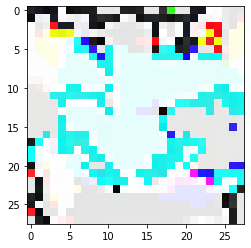

In [ ]:
import numpy as np
# show a random n
random_index =31
out = samples[-1][random_index].transpose(1,2,0)
plt.imshow((out*28).astype(np.uint8))

In [ ]:

save_path = './linear_beta_100.pt'.format(epoch)
output = open(save_path, mode="wb")
torch.save(model.state_dict(), output)
print("save all model to {}".format(save_path))

save all model to ./linear_beta_100.pt
